## Matching BCG galaxies to RM Center

In [2]:
from scipy.stats import kde
from scipy.spatial import KDTree
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm
import pickle
from astropy import table
from astropy.table import Table, join, unique

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing Catalogs

In [4]:
DESI_directory = '/pscratch/sd/z/zwshao/shared_zzhang13/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.3/'
os.listdir(DESI_directory)

['BGS_BRIGHT-21.5_full_HPmapcut.dat.fits',
 'BGS_ANY_NGC_clustering.dat.fits',
 'BGS_BRIGHT_full_HPmapcut.dat.fits',
 'BGS_ANY_SGC_clustering.dat.fits',
 'LRG_clustering.dat.fits',
 'LRG_full_noveto.dat.fits',
 'BGS_ANY_full.dat.fits',
 'BGS_ANY_full_HPmapcut.dat.fits',
 'BGS_BRIGHT_NGC_clustering.dat.fits',
 'BGS_BRIGHT-21.5_SGC_clustering.dat.fits',
 'LRG+ELG_LOPnotqso_NGC_clustering.dat.fits',
 'BGS_BRIGHT-21.5_clustering.dat.fits',
 'BGS_ANY_clustering.dat.fits',
 'LRG+ELG_LOPnotqso_SGC_clustering.dat.fits',
 'LRG_full.dat.fits',
 'BGS_BRIGHT_clustering.dat.fits',
 'BGS_BRIGHT_SGC_clustering.dat.fits',
 'LRG_NGC_clustering.dat.fits',
 'LRG_full_HPmapcut.dat.fits',
 'BGS_BRIGHT_full_noveto.dat.fits',
 'BGS_BRIGHT-21.5_NGC_clustering.dat.fits',
 'BGS_ANY_full_noveto.dat.fits',
 'BGS_BRIGHT_full.dat.fits',
 'LRG_SGC_clustering.dat.fits']

### redMapper Catalog

_x is for the BCG or cluster property
_y is for individual galaxies

In [5]:
with open('RM_SDSS_df.pkl', 'rb') as handle:
    RM_df = pickle.load(handle)
rm_data = Table.from_pandas(RM_df)
sparse_sampling = 1
rm_data = rm_data[::sparse_sampling]

##Remove clusters with bad spectroscopic redshift & Above BCG threshold
cut = np.where((rm_data['Z_SPEC_x'] > 0) & (rm_data['Z_SPEC_x'] < 0.4) &\
                (rm_data['Z_SPEC_x'] > 0) &\
                (rm_data['Z_SPEC_y'] != rm_data['Z_SPEC_x'])) ##Removes double counting satellite with central galaxies
rm_data = rm_data[cut]

In [6]:
rm_data.columns

<TableColumns names=('ID','NAME','RA_x','DEC_x','Z_LAMBDA','Z_LAMBDA_ERR','LAMBDA','LAMBDA_ERR','S','Z_SPEC_x','OBJID_x','IMAG_x','IMAG_ERR_x','MODEL_MAG_U_x','MODEL_MAGERR_U_x','MODEL_MAG_G_x','MODEL_MAGERR_G_x','MODEL_MAG_R_x','MODEL_MAGERR_R_x','MODEL_MAG_I_x','MODEL_MAGERR_I_x','MODEL_MAG_Z_x','MODEL_MAGERR_Z_x','ILUM','RA_y','DEC_y','R','P','P_FREE','THETA_I','THETA_R','IMAG_y','IMAG_ERR_y','MODEL_MAG_U_y','MODEL_MAGERR_U_y','MODEL_MAG_G_y','MODEL_MAGERR_G_y','MODEL_MAG_R_y','MODEL_MAGERR_R_y','MODEL_MAG_I_y','MODEL_MAGERR_I_y','MODEL_MAG_Z_y','MODEL_MAGERR_Z_y','Z_SPEC_y','OBJID_y','R_LAMBDA')>

In [7]:
##Split into a cluster and galaxy sample
rm_clus = rm_data[['ID','LAMBDA','Z_LAMBDA','R_LAMBDA','Z_SPEC_x','RA_x','DEC_x', 'MODEL_MAG_R_x','MODEL_MAGERR_R_x']]
rm_gal = rm_data[['ID', 'Z_SPEC_y','RA_y','DEC_y', 'R', 'P', 'MODEL_MAG_R_y','MODEL_MAGERR_R_y']]
rm_clus = table.unique(rm_clus,keys='ID')

### BGS Catalog

In [8]:
bgs_data = Table.read(DESI_directory + 'BGS_ANY_clustering.dat.fits')
bgs_data.columns

<TableColumns names=('TARGETID','Z','NTILE','RA','DEC','PHOTSYS','FRAC_TLOBS_TILES','WEIGHT_ZFAIL','WEIGHT','WEIGHT_COMP','WEIGHT_SYS','flux_g_dered','flux_r_dered','flux_z_dered','flux_w1_dered','flux_w2_dered','BITWEIGHTS','PROB_OBS')>

In [9]:
bgs_data.rename_columns(['RA','DEC','Z'],['RA_BGS','DEC_BGS','Z_BGS'])
bgs_data = bgs_data[['TARGETID','RA_BGS','DEC_BGS','Z_BGS', 'WEIGHT', \
                'flux_g_dered','flux_r_dered','flux_z_dered','flux_w1_dered','flux_w2_dered']]

### Old Stuff

## Matching the catalogs

This matches the BGS catalogs that are within 1.5 Mpc comoving distance to the RM center in Planck18 cosmology. To do so we first match by 2D aperture then by distance assuming the galaxies are the same distance as the RM. We do this two step process as SkyCoord is unable to match directly by 2D distance separation.

In [10]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18

### First match by 2D aperture. 

In [11]:
rm_z = rm_clus['Z_SPEC_x'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving")) ##In units of Mpc/h
bgs_z = bgs_data['Z_BGS'] * cu.redshift
bgs_d = bgs_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving")) #In units of Mpc/h
## Masking the bad redshifts
bgs_d[np.where(bgs_d < 0)] = 0 

In [12]:
rm_c = SkyCoord(ra=rm_clus['RA_x']*u.degree, dec=rm_clus['DEC_x']*u.degree, distance = rm_d)
bgs_c = SkyCoord(ra=bgs_data['RA_BGS']*u.degree, dec=bgs_data['DEC_BGS']*u.degree, distance = bgs_d)

## Search around each RM
max_sep = 15 * u.arcmin
idxc, idxcatalog, d2d, d3d = bgs_c.search_around_sky(rm_c, max_sep)
np.all(d2d < max_sep)

rm_clus_matched = rm_clus[idxc]
bgs_matched = bgs_data[idxcatalog]

In [13]:
## Fill in ones that are RM_galaxy matched
for i, col in enumerate(rm_clus_matched.columns):
    bgs_matched[col] = rm_clus_matched[col]

bgs_matched = unique(bgs_matched, keys='TARGETID')

smallz = bgs_matched[np.where(np.abs(bgs_matched['Z_BGS']-bgs_matched['Z_SPEC_x'])/(1+bgs_matched['Z_BGS']) < 0.1)]
rm_z = smallz['Z_SPEC_x'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))


#Compute distances
r = haversine(smallz['RA_BGS'], smallz['DEC_BGS'], smallz['RA_x'], \
              smallz['DEC_x'], r=1)

NameError: name 'haversine' is not defined

In [ ]:
plt.hist(r.value/(2*np.pi)*57.2958, bins=100, range=(0,1))
#plt.xlabel('r (Mpc/h)')
plt.show()

### Then match by 3D distance

Match radius 1.5 Mpc assuming galaxies are the same distance as the RM cluster.

In [37]:
rm_z = rm_clus_matched['Z_SPEC_x'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving")) #Units of Mpc/h
## Masking the bad redshifts
bgs_d[np.where(bgs_d < 0)] = 0 

In [38]:
#Match the galaxy distances on the sky to the matched RM distance
rm_c = SkyCoord(ra=rm_clus_matched['RA_x']*u.degree, dec=rm_clus_matched['DEC_x']*u.degree, distance = rm_d)
bgs_c = SkyCoord(ra=bgs_matched['RA_BGS']*u.degree, dec=bgs_matched['DEC_BGS']*u.degree, distance = rm_d)

In [39]:
## Search around each RM
max_sep = 1.5 * u.Mpc
idxc, idxcatalog, d2d, d3d = bgs_c.search_around_3d(rm_c, max_sep)
np.all(d3d < max_sep)

rm_clus_matched = rm_clus_matched[idxc]
bgs_matched = bgs_matched[idxcatalog]
print("Match rate: ", len(table.unique(rm_clus_matched, keys='ID'))/len(rm_clus))

## Fill in ones that are RM_galaxy matched
for i, col in enumerate(rm_clus_matched.columns):
    bgs_matched[col] = rm_clus_matched[col]

Match rate:  0.6362789831455443


### Then match by redshift 
* Choose only galaxies in redshift range of $|\frac{(z_{bgs}-z_{rm})}{(1 + z_{bcg})}| < 0.2$

In [40]:
zcut = np.abs((bgs_matched['Z_BGS'] - bgs_matched['Z_SPEC_x']))/(1+bgs_matched['Z_BGS']) <= 0.2
bgs_matched = bgs_matched[zcut]

### Matching BGS galaxies with RM members

Using angular separation.

Test if this steps creates the over-counting bug. 

## Testing why there are so many $\Delta z < 0.0001$ clusters

They have to do with distance. Figure out what's causing them? Repeating galaxies?

In [41]:
def haversine(lon1, lat1, lon2, lat2, r=1):
    """
    Calculate the great circle distance in kilometers between two points (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    return c*r

In [47]:
def spherical_to_cartesian(ra, dec):
    """
    Calculate cartesian coordinates on a unit sphere given two angular coordinates.
    parameters

    Parameters
    -----------
    ra : array
        Angular coordinate in degrees

    dec : array
        Angular coordinate in degrees

    Returns
    --------
    x,y,z : sequence of arrays
        Cartesian coordinates.

    Examples
    ---------
    >>> ra, dec = 0.1, 1.5
    >>> x, y, z = spherical_to_cartesian(ra, dec)

    """

    rar = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    return x, y, z

In [59]:
bgs_matched = unique(bgs_matched, keys='TARGETID')

In [60]:
smallz = bgs_matched[np.where(np.abs(bgs_matched['Z_BGS']-bgs_matched['Z_SPEC_x'])/(1+bgs_matched['Z_BGS']) < 0.0001)]
rm_z = smallz['Z_SPEC_x'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))


#Compute distances
r = haversine(smallz['RA_BGS'], smallz['DEC_BGS'], smallz['RA_x'], \
              smallz['DEC_x'], r=rm_d)

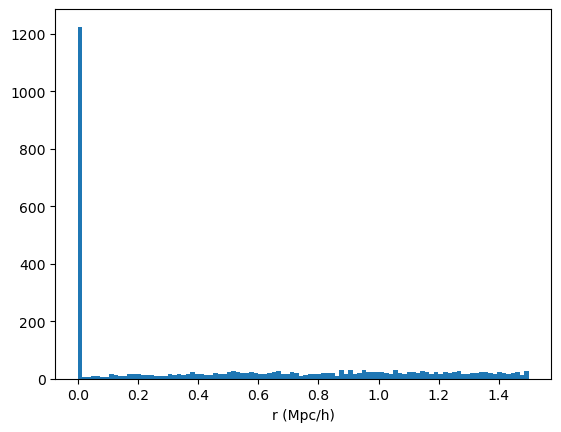

In [61]:
plt.hist(r, bins=100)
plt.xlabel('r (Mpc/h)')
plt.show()

### Removing the problem with too many galaxies near the center

Allow the BCGs to only match with one. If the BGS galaxy is within multiple clusters find the biggest one. Remove 

## Plotting

In [33]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.polynomial import Chebyshev1D, Polynomial1D
from astropy.modeling.functional_models import Linear1D
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
import linetools

In [34]:
from specutils import SpectralRegion
exclude_regions = [SpectralRegion(-0.05 * u.um, 0.05 * u.um)]

In [35]:
#Bin by richness
lmda_bins = [[20,30],[30,50],[50,300]] #upper limit must match lower limit of next bin

## Bin by redshift
z_bins = [[0.15,0.2],[0.2,0.3],[0.3,0.4]]

In [36]:
small_bin = np.linspace(-0.01,0.01,51)
wide_bin_1 = np.linspace(-0.1,-0.01,51)
wide_bin_2 = np.linspace(0.01,0.1,51)

binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])

In [37]:
len(np.where(bgs_matched['Z_SPEC_y'] == bgs_matched['Z_SPEC_x'])[0])

0

## Doing the sampling for RM galaxies only

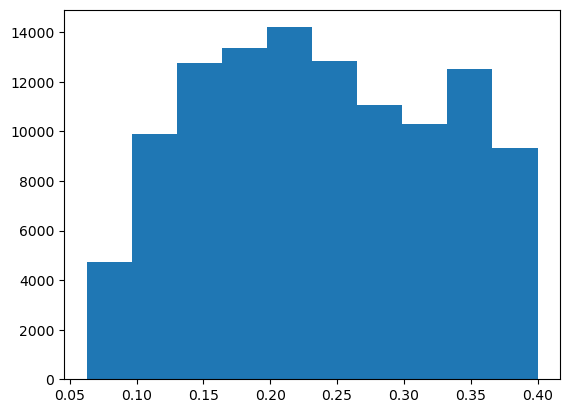

In [38]:
plt.hist(bgs_matched['Z_SPEC_x'])
plt.show()

In [39]:
z_diff = (bgs_matched['Z_SPEC_x'] - bgs_matched['Z_SPEC_y'])/(1+bgs_matched['Z_SPEC_x'])
val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
numCount, bin_edges = np.histogram(z_diff, bins=binBoundaries, density=False) 

##For Poissonian noise
#numCount[np.where(numCount<=0)] = 1 #Avoid dividing by 0 or NAN
#y_err = np.sqrt(numCount)
#y_err *= val/numCount
#y_err += 0.001 ## Add small number to avoid blowing up
y_err = np.sqrt(val)
y_err[np.where(y_err==0)] = 1


spectrum = Spectrum1D(flux=val*u.Jy, spectral_axis=binCent*u.um)
g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(5), median_window=3, exclude_regions=exclude_regions)
y_continuum_fitted_1 = g1_fit(binCent*u.um)

            
##Take Poisson error before subtracting the continuum
y_err = np.sqrt(val)
y_err[np.where(y_err==0)] = 1 ## Ad hoc method to correct for bins with 0

#val -= y_continuum_fitted_1.value

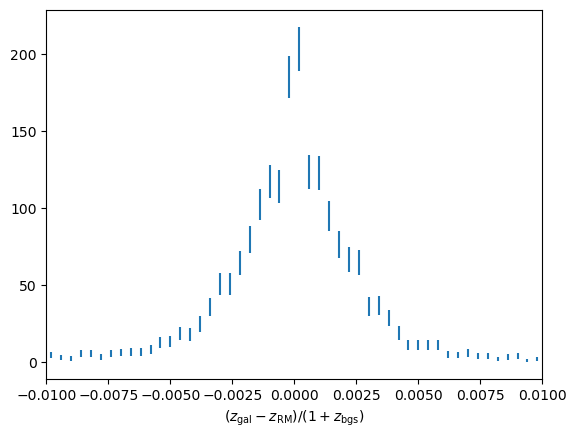

In [40]:
plt.errorbar(binCent, val, yerr=np.sqrt(val), linestyle='none')
plt.xlabel(r"$(z_{\rm{gal}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$")
#plt.errorbar(binCent, val-y_continuum_fitted_1.value, yerr=np.sqrt(val))
#plt.yscale('symlog', linthresh=1)
plt.xlim([-0.01,0.01])
plt.show()

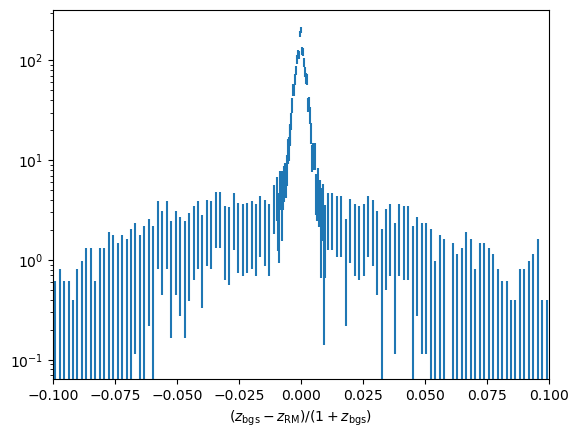

In [41]:
plt.errorbar(binCent, val, yerr=np.sqrt(val), linestyle='none')
plt.xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$")
#plt.errorbar(binCent, val-y_continuum_fitted_1.value, yerr=np.sqrt(val))
plt.yscale('log')
plt.xlim([-0.1,0.1])
plt.show()

## Geometric Fraction

In [113]:
## Import the halo catalog
aper = 1.5 # units: Mpc/h
randDensity = 2500 #random points per sq. deg
h = Planck18.H(0).value/100
rad2deg= 57.2958
arcsec2deg = 1./3600.

##Should there be a Hubble scaling??
rm_clus['angRad'] = aper*(Planck18.arcsec_per_kpc_comoving(rm_clus['Z_SPEC_x']).value*1000)*arcsec2deg
#rm_clus['D_comoving'] = Planck18.comoving_distance(rm_clus_matched['Z_SPEC_x']) #Should multiple by hubble?
rm_clus['pos'] = np.array(spherical_to_cartesian(rm_clus['RA_x'], rm_clus['DEC_x'])).T
#rm_clus[f'{aper}Mpc_arc'] = aper/rm_clus['D_comoving']
rm_clus['sq_deg'] = np.pi*rm_clus['angRad']**2
rm_clus[f'Nr_{aper}Mpc_expected'] = rm_clus['sq_deg']*randDensity
rm_clus['geoFrac'] = 0.

In [114]:
numRand = 18
desiDir = '/global/cfs/cdirs/desi/survey/catalogs/dr1/LSS/iron/LSScats/v1.5pip/'
for i in range(numRand):
    randomCat = "BGS_ANY_{}_full_HPmapcut.ran.fits".format(i)
    print(randomCat)
    ran_data = Table.read(desiDir + randomCat)
    ran_data['pos'] = np.array(spherical_to_cartesian(ran_data['RA'], ran_data['DEC'])).T

    # Constructing KDTree for pair counting
    rtree = KDTree(ran_data['pos'])

    # Number of random points
    rm_clus[f"Nr_{aper}Mpc"] = np.asarray(rtree.query_ball_point(rm_clus['pos'].data, \
                                            rm_clus['angRad']/rad2deg, workers=100, return_length=True), dtype=float)
    rm_clus['geoFrac'] += rm_clus[f"Nr_{aper}Mpc"]/rm_clus[f'Nr_{aper}Mpc_expected']

rm_clus['geoFrac'] /= numRand

BGS_ANY_0_full_HPmapcut.ran.fits
BGS_ANY_1_full_HPmapcut.ran.fits
BGS_ANY_2_full_HPmapcut.ran.fits
BGS_ANY_3_full_HPmapcut.ran.fits
BGS_ANY_4_full_HPmapcut.ran.fits
BGS_ANY_5_full_HPmapcut.ran.fits
BGS_ANY_6_full_HPmapcut.ran.fits
BGS_ANY_7_full_HPmapcut.ran.fits
BGS_ANY_8_full_HPmapcut.ran.fits
BGS_ANY_9_full_HPmapcut.ran.fits
BGS_ANY_10_full_HPmapcut.ran.fits
BGS_ANY_11_full_HPmapcut.ran.fits
BGS_ANY_12_full_HPmapcut.ran.fits
BGS_ANY_13_full_HPmapcut.ran.fits
BGS_ANY_14_full_HPmapcut.ran.fits
BGS_ANY_15_full_HPmapcut.ran.fits
BGS_ANY_16_full_HPmapcut.ran.fits
BGS_ANY_17_full_HPmapcut.ran.fits


In [115]:
bgs_matched = join(bgs_matched, rm_clus[['ID', 'geoFrac']], keys='ID', join_type='inner')

## Save output

In [116]:
#output_dir = '/pscratch/sd/z/zzhang13/DESI/'

In [118]:
with open('bgs_clus_RM_gal_matched.pickle', 'wb') as handle:
    pickle.dump(bgs_matched, handle, protocol=pickle.HIGHEST_PROTOCOL)

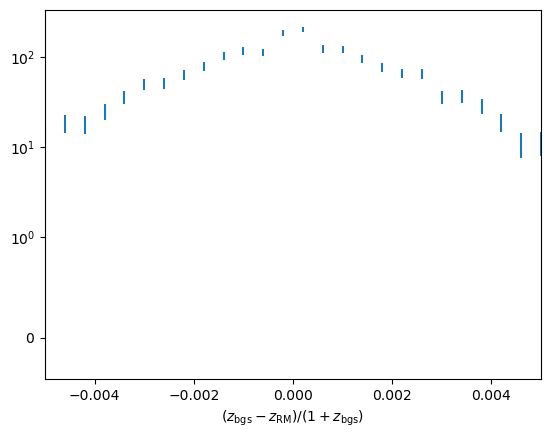

In [42]:
plt.errorbar(binCent, val, yerr=np.sqrt(val), linestyle='none')
plt.xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$")
plt.yscale('symlog', linthresh=1)
plt.xlim([-0.005,0.005])
plt.show()

## MCMC Modeling

In [42]:
def lnprior(p):
    sigma_1 = p[2]; sigma_2 = p[5]

    if (sigma_1 > 0.01) or (sigma_1 <= 0):
        return -np.inf

    if (sigma_2 <= 0.01) or (sigma_2 > 0.11):
        return -np.inf

    return 0

'''
Gaussian likelihood with heterodescitic errors.

Input:
p: 4-parameters of dimensions (N) or (N,M) with N the array of posterior samples
model: functional model for the fit (see functions below)
x: x data vector
y: y data vector
err: error on the y data vector

Returns:
lp: log probability
'''
def lnlike(p, model, x, y, err):
    # the likelihood is sum of the lot of normal distributions
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    err = err[:,np.newaxis]
    
    fit = model(p,x)
    if np.any(np.isnan(fit)):
        return -np.inf

    denom = np.power(err,2)
    lp = -0.5*np.sum(np.power((y - fit),2)/denom + np.log(denom) + np.log(2*np.pi), axis=0)
    lp = np.nan_to_num(lp, nan=-np.inf)
    return lp

'''
Double Gaussian model

def model(p,x):
    A_1 = p[0]; mu_1 = p[1]; sigma_1 = p[2]; A_2 = p[3]; mu_2 = p[4]; sigma_2 = p[5]
    #x = x[:,np.newaxis]
    model = A_1/np.sqrt(2*np.pi*sigma_1**2)* np.exp(-(x - mu_1) ** 2 / (2 * sigma_1 ** 2)) \
            +A_2/np.sqrt(2*np.pi*sigma_2**2)* np.exp(-(x - mu_2) ** 2 / (2 * sigma_2 ** 2))
    return model
'''

'''
Double Gaussian model with mean at 0
'''
def model(p,x):
    A_1 = p[0]; mu_1 = p[1]; sigma_1 = p[2]; A_2 = p[3]; mu_2 = p[4]; sigma_2 = p[5];
    
    #x = x[:,np.newaxis]
    model = A_1/np.sqrt(2*np.pi*sigma_1**2)* np.exp(-(x - mu_1) ** 2 / (2 * sigma_1 ** 2)) \
            +A_2/np.sqrt(2*np.pi*sigma_2**2)* np.exp(-(x - mu_2) ** 2 / (2 * sigma_2 ** 2))
    return model  

def lnprob(p, model, x, y, err):
    lp = lnprior(p)

    return lp + lnlike(p, model, x, y, err)
   

In [260]:
#Bin by richness
lmda_bins = [[20,30],[30,50],[50,300]] #upper limit must match lower limit of next bin

## Bin by redshift
z_bins = [[0.15,0.2],[0.2,0.3],[0.3,0.4]]

In [319]:
wide_bin_1 = np.linspace(-0.1,-0.01,51)
small_bin = np.linspace(wide_bin_1[-1]+0.001,0.01,101)
wide_bin_2 = np.linspace(small_bin[-1]+0.001,0.1,51)

binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])

In [320]:
from specutils import SpectralRegion
#exclude_regions = [SpectralRegion(-0.03 * u.um, 0.03 * u.um)]

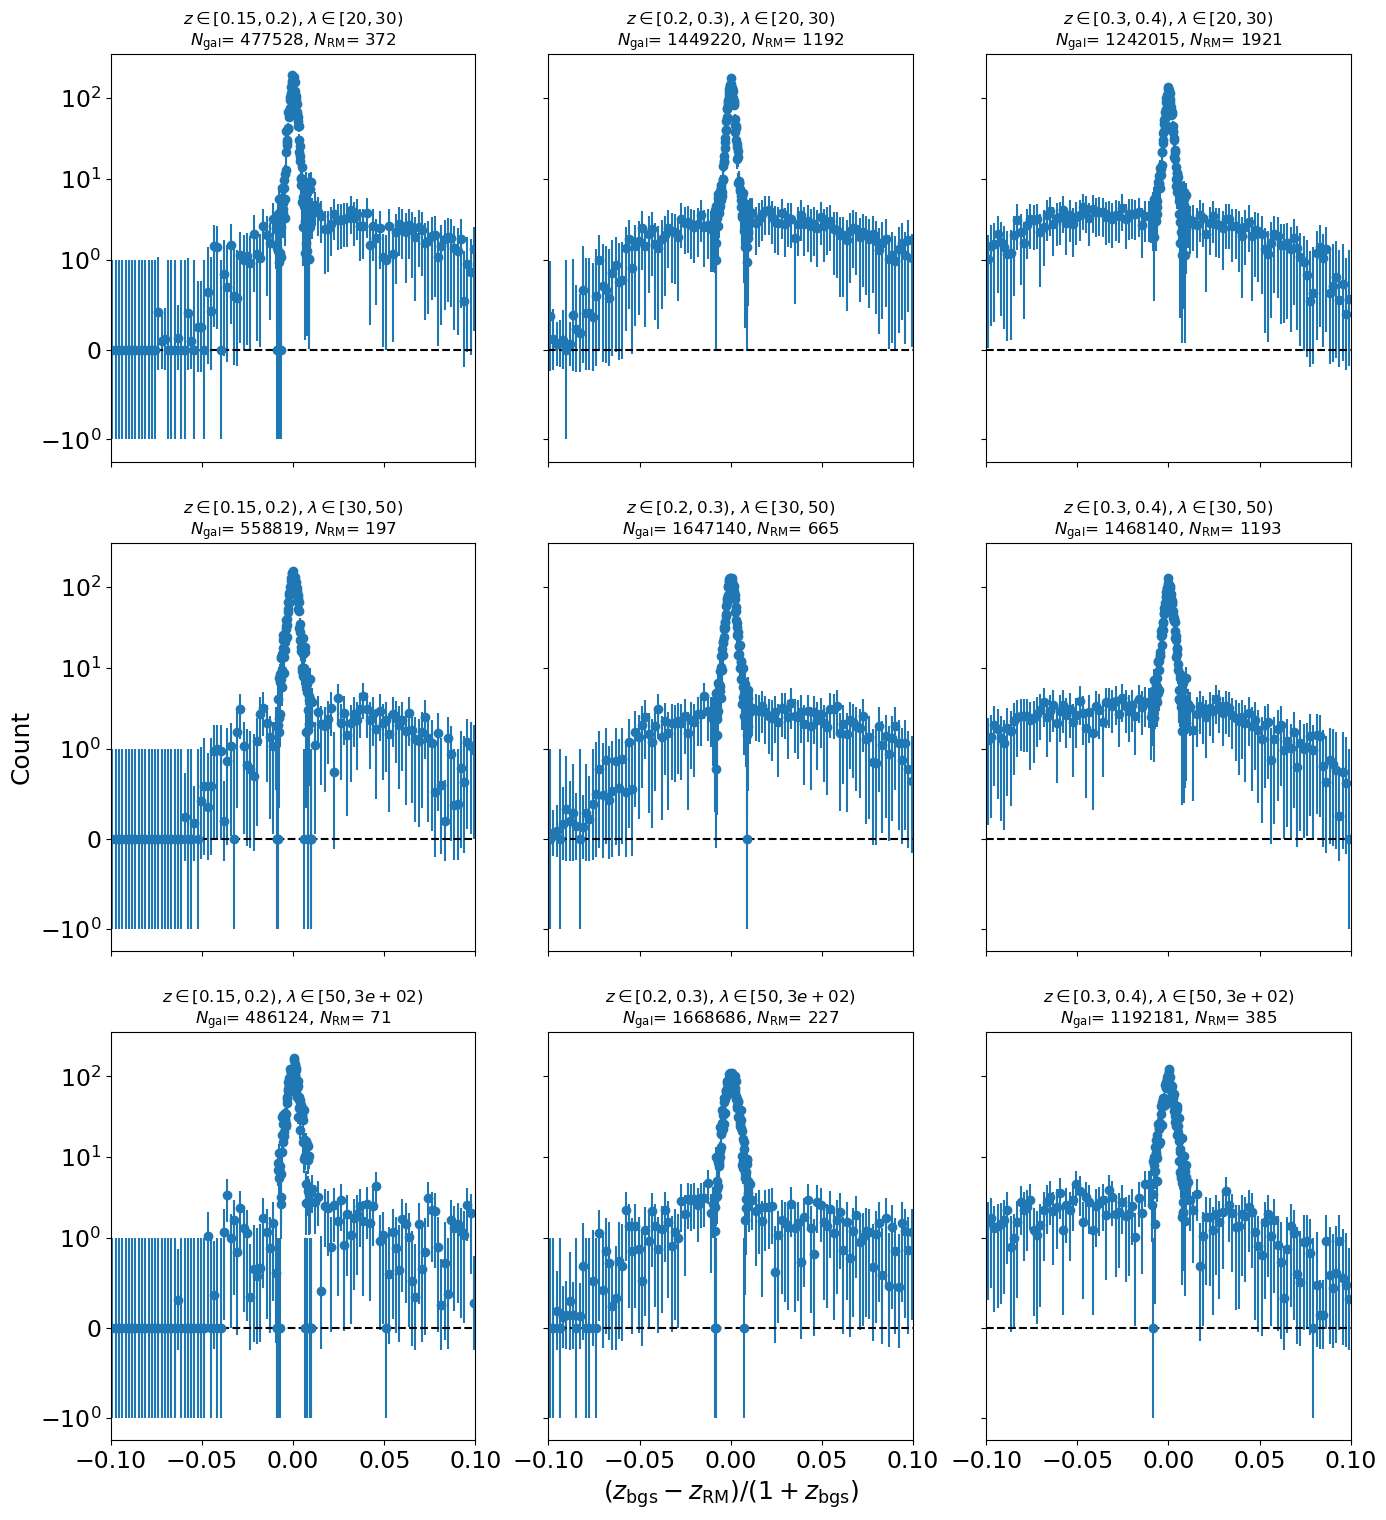

In [321]:
output_dict = {}

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,18), sharex='all', sharey='all')
#fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):

            bin_dict = {}
            
            ##Apply binning
            cut = (rm_data_matched['LAMBDA'] >= lmda_bin[0]) & (rm_data_matched['LAMBDA'] < lmda_bin[1])
            cut &=(rm_data_matched['Z_LAMBDA'] >= z_bin[0]) & (rm_data_matched['Z_LAMBDA'] < z_bin[1])
            rm_bin = rm_data_matched[cut]
            z_diff = (rm_bin['Z_DESI'] - rm_bin['Z_SPEC_x'])/(1+rm_bin['Z_SPEC_x'])

            ##Binning and exlude regions
            #z_diff = (rm_bin['Z_SPEC_x'] - bgs_bin['Z'])/(1+rm_bin['Z_SPEC_x'])
            y_data, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
            #spectrum = Spectrum1D(flux=y_data*u.Jy, spectral_axis=binCent*u.um)
            #g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(3), median_window=5, exclude_regions=exclude_regions)
            #linear_fit = fit_generic_continuum(spectrum, model=Linear1D(), median_window=5, exclude_regions=exclude_regions)
            #y_continuum_fitted_1 = g1_fit(binCent*u.um)
            #linear_fitted = linear_fit(binCent*u.um)

            
            ##Take Poisson error before subtracting the continuum
            y_err = np.sqrt(y_data)
            y_err[np.where(y_err==0)] = 1 ## Ad hoc method to correct for bins with 0

            #y_fitted = y_data- y_continuum_fitted_1.value

            ## Apply redshift difference cut
            cut = (binCent >= -0.1) & (binCent < 0.1)
            y_data = y_data[cut]
            y_err = y_err[cut]
            x_data = binCent[cut]
            #y_continuum_fitted_1 = y_continuum_fitted_1[cut]
            #linear_fitted = linear_fitted[cut]


            ax[i,j].errorbar(x_data, y_data, yerr=y_err, linestyle='none', marker='o')
            #ax[i,j].plot(x_data, y_continuum_fitted_1)
            #ax[i,j].plot(x_data, linear_fitted)
            ax[i,j].set_yscale('symlog', linthresh=1)
            ax[i,j].set_xlim([-0.1,0.1])
            ax[i,j].axhline(0, linestyle='--', color='black')
            #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)
            ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                                  r'$\lambda \in [{:.2g},{:.2g})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                                  r'$N_{\rm gal}$' + '= {:d}'.format(len(rm_bin)) \
                                  + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(rm_bin['ID']))))
               
            ax[1,0].set_ylabel(r"Count", fontsize=18)
            ax[2,1].set_xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$"  , fontsize=18)


            bin_dict['y_data'] = y_data
            bin_dict['y_err'] = y_err
            bin_dict['x_data'] = x_data
            output_key = 'lmda{:d}_{:d}_z{:.2f}_{:.2f}'.format(lmda_bin[0], lmda_bin[1], z_bin[0], z_bin[1])
            output_dict[output_key] = bin_dict

plt.show()

In [323]:
with open('z_diff_profiles.pkl', 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Run Chains 

In [324]:
with open('z_diff_profiles.pkl', 'rb') as handle:
    input_dict = pickle.load(handle)

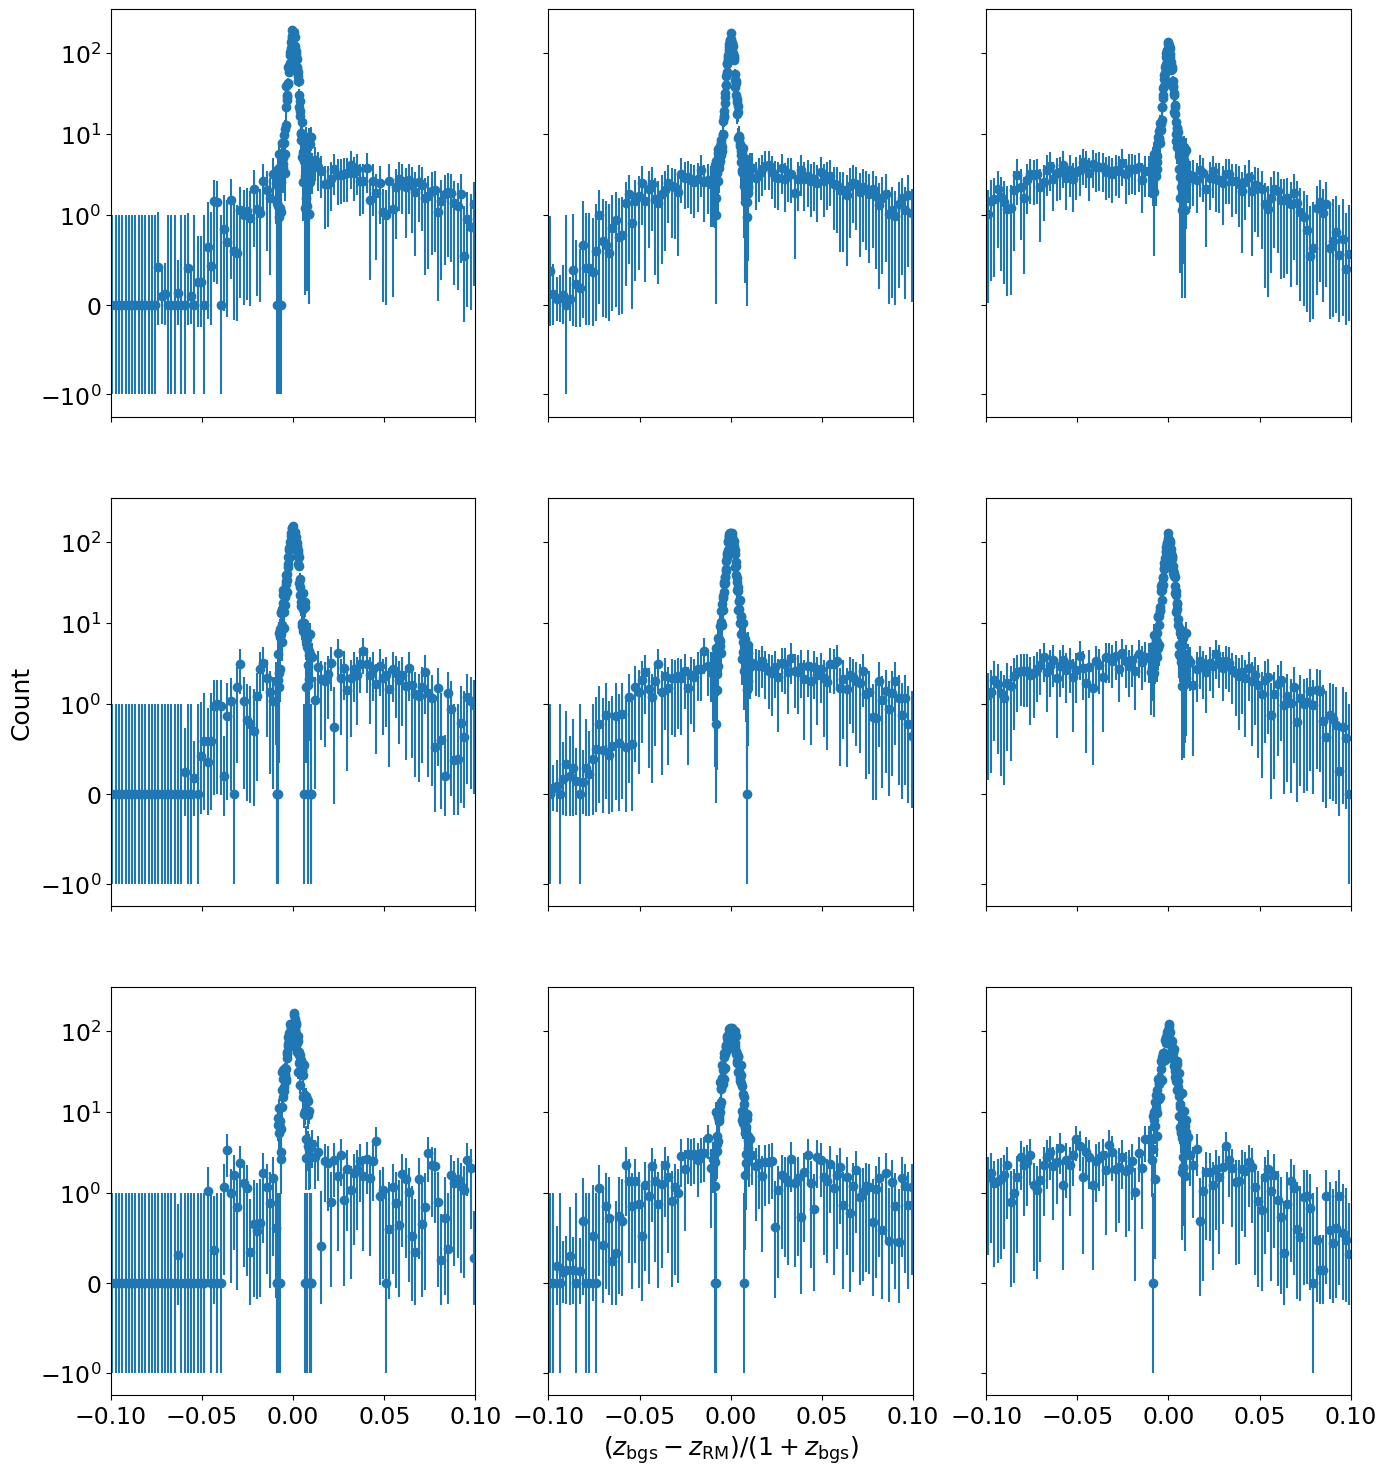

In [325]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,18), sharex='all', sharey='all')
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):
        input_key = 'lmda{:d}_{:d}_z{:.2f}_{:.2f}'.format(lmda_bin[0], lmda_bin[1], z_bin[0], z_bin[1])
        bin_dict = input_dict[input_key]

        y_data = bin_dict['y_data']
        y_err = bin_dict['y_err']
        x_data = bin_dict['x_data']
        
        ax[i,j].errorbar(x_data, y_data, yerr=y_err, linestyle='none', marker='o')
        ax[i,j].set_yscale('symlog', linthresh=1)
        ax[i,j].set_xlim([-0.1,0.1])
        #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
        ax[i,j].tick_params(axis='both', which='major', labelsize=17)
        #ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
        #                      r'$\lambda \in [{:.2g},{:.2g})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
        #                      r'$N_{\rm gal}$' + '= {:d}'.format(len()) \
        #                      + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(rm_bin))))
           
        ax[1,0].set_ylabel(r"Count", fontsize=18)
        ax[2,1].set_xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$"  , fontsize=18)
        
plt.show()       

### Chain Setup

In [369]:
Nwalkers = 30
Nsample = int(1e4)
Ndim = 6 ## For Double Gaussian model
chains_dir = 'chains/'

In [370]:
starting_params = [0.2, 0.0001, 0.003, 0.3, 0.0001, 0.05]
p0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(Ndim)) for j in range(Nwalkers)])

In [371]:
starting_model = model(starting_params, binCent)

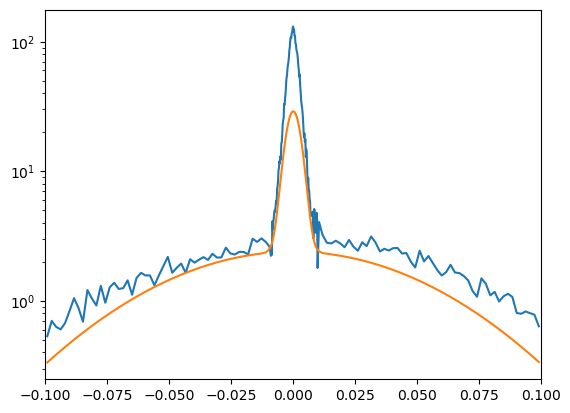

In [372]:
z_diff = (rm_data_matched['Z_DESI'] - rm_data_matched['Z_SPEC_x'])/(1+rm_data_matched['Z_DESI'])
val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
plt.plot(binCent, val)
plt.plot(binCent, starting_model)
plt.yscale('log')
plt.xlim([-0.1,0.1])
plt.show()

In [373]:
from scipy import stats

'''
Calculates the BIC for a given model.
model: function that inputs model
samples: flattened chain of (D,N), D the number of dimension and N total number of samples across all walkers;
x_data: x coordinates for data vectors
y_data: y coordinates for data vectors
y_err: y errors on the data points
'''
def BIC(model,samples, x_data, y_data, y_err):
    k = np.shape(samples)[0]
    p_best = list(map(lambda v: (v[0]), zip(*np.percentile(samples, [50], axis=1))))
    D = -2*lnlike(p_best, model, x_data, y_data, y_err)
    N = len(x_data)
    return D + k*np.log(N)


'''
model: function that inputs model
samples: flattened chain of (D,N), D the number of dimension and N total number of samples across all walkers;
data: data vector
best_p: best fit parameters
'''

def DIC(model, samples, x_data, y_data, y_err):
        """
        Compute the Deviance Information Criterion for the given model
        """
        # Compute the deviance D for each sample, using the vectorized code.
        
        ##This part needs to be completed. 
        D_avg = np.mean(-2.0*lnlike(samples, model, x_data, y_data, y_err)) ## Vectorized
        p_best = list(map(lambda v: (v[0]), zip(*np.percentile(samples, [50], axis=1))))
        
        D_best = -2.0**lnlike(p_best, model, x_data, y_data, y_err)
        DIC = 2*D_avg - D_best
        return DIC

'''
Calculates the DIC for a given model.
model: best fit model of dimensions (len(x),)
obs: Observed y data points
error: Error on the y-data points
'''
## Chi_squared estimator
def chisqr(model, obs, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-model[i])**2)/(error[i]**2)
    return chisqr


'''
chain: np.array in dimensions of (nsteps, nwalk, npars).  
model: The functional form of the model
Ndim: number of parameters for the model
x_data: the x data vector
y_data: the y data vector
y_err: error on the y data vector
verbose: If true, displays the best fit parameters and bounds, DIC, BIC and Chi-square right-tail p-value

Returns:
best_fit_params: (Ndim,3) array of the best fit parameters. For each parameter the 2nd axes denote [best_fit_val, upper_err, lower_err] using the (16,50,84) percentile bounds 
DIC_model: The DIC of the model
BIC_model: The BIC of the model
p_val: Chi-square right tail p-value
'''
def posterior_summary_stats(chain, model, Ndim, x_data, y_data, y_err, verbose=False):
    
    ##Turn into a flatchain
    flatchain = chain.reshape((-1,Ndim)).T
    
    ##Best fit parameters
    params_iter = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(flatchain, [16, 50, 84], axis=1)))
        
    best_fit_params = []
    for i, param_cur in enumerate(params_iter):
        best_fit_params.append(list(param_cur))
        
    best_fit_params = np.array(best_fit_params)
    model_best_fit = model(best_fit_params[:,0], x_data)
    
    ##Chi-square p-value
    p_val = 1 - stats.chi2.cdf(chisqr(model_best_fit, y_data, y_err) , len(y_data)-Ndim)
    
    ###DIC 
    reduce_sample = 1 #int(np.shape(flatchain)[1]/100) ## Count every 1000  
    DIC_model =  DIC(model, flatchain[:,::reduce_sample],  x_data, y_data, y_err)
    BIC_model =  BIC(model, flatchain[:,::reduce_sample],  x_data, y_data, y_err)
    
    if verbose:
        ##Check the convergence of chains
        check_chains(chain)
        
        ##Best fit params
        for i in range(len(best_fit_params)):
            print('param_{}: best fit, upper_err, lower_err: '.format(i), best_fit_params[i])
            
        ##DIC and BIC
        print("DIC: ", DIC_model)
        print("BIC: ", BIC_model)

        ##Chi-square p-value
        print('Chi-square: ', chisqr(model_best_fit, y_data, y_err))
        print('Chi-square p-value: ', p_val)
        
    return best_fit_params, DIC_model, BIC_model, p_val


In [374]:
'''
Runs the chains, outputs and prints summary stats, and saves the chains onto a H5PY file. 

Nwalkers: Number of walkers
Ndim: Number of dimensions for the model
Nsample: Number of sample per chain
x_data: x data vector
y_data: y data vector
y_err: error on the y data vector
x0: Initialization parameters for the model, should be length Ndim
burn_in: (Optional) number of posterior samples to burn
thin: Thin by amount
maxlag: Max autocorrelation lag to compute to check chain convergence
savefile: Boolean to save the file
filename: directory and filename
verbose: If true, outputs Starting params minimization convergence, autocorrelation time as computed by GW10, GelmanRubin R correlation, DIC, BIC, Chi-square left tail p-value

Returns:
best_fit_params: (Ndim,3) array of the best fit parameters. For each parameter the 2nd axes denote [best_fit_val, upper_err, lower_err] using the (16,50,84) percentile bounds 
chain: UNFLATTENED chain of dimension (Nsteps, Ndim, Nparam) after thinning and burn in

'''
def run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, 
                     burn_in=100, thin=100, maxlag=1000, savefile=True, filename='test.h5py', verbose=False): 
        
    ##Initial guess
    ## use the scipy minimze method to find the best fit parameters as the starting point
    #nll = lambda *args: -lnlike(*args)
    #result = opt.minimize(nll, x0=x0,
    #                          args=(model, x_data, y_data, y_err), method='Nelder-Mead', options={'gtol': 1e-6, 'disp': verbose}) 
    #starting_params = result['x']
    starting_params = x0
    
    p0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(Ndim)) for j in range(Nwalkers)])


    # Initialize the sampler        
    sampler = emcee.EnsembleSampler(Nwalkers, Ndim, lnprob,
                    args=(model, x_data, y_data, y_err)) ##No backend
        
    sampler.run_mcmc(p0, Nsample, progress=verbose) 
    chain = sampler.get_chain(flat=False, thin=thin, discard=burn_in)
    flatchain = sampler.get_chain(flat=True, thin=thin, discard=burn_in).T
    best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(chain, model, Ndim, x_data, y_data, y_err, verbose=verbose)
    
    #if verbose:
        #print("Starting params: ", starting_params, "Minimization convergence: ", result['success'])
        #tau = sampler.get_autocorr_time(quiet=True)
        #print("Autocorrelation: ", tau)
        #check_chains(chain, 1, maxlag=maxlag)
        
    
    sampler.reset()
 
    ##Save the files
    if savefile:
        with h5py.File(filename, "w") as f:
            f.create_dataset("chains",data=chain)
            f.close()

    return best_fit_params, chain

def check_chains(chain, burn=0, maxlag=1000):
    '''
    Ignoring `burn` samples from the front of each chain, compute convergence criteria and
    effective number of samples.
    '''
    nsteps, nwalk, npars = chain.shape
    if burn >= nsteps: return
    tmp_samples = [chain[burn:,i,:] for i in range(nwalk)]
    print('R =', cr.GelmanRubinR(tmp_samples))
    #print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
    #print('NB: Since walkers are not independent, these will be optimistic!')
    return

In [375]:
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):

        input_key = 'lmda{:d}_{:d}_z{:.2f}_{:.2f}'.format(lmda_bin[0], lmda_bin[1], z_bin[0], z_bin[1])
        bin_dict = input_dict[input_key]
        input_key = input_key.replace('.','p')
        
        y_data = bin_dict['y_data']
        y_err = bin_dict['y_err']
        x_data = bin_dict['x_data']

        run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, starting_params, 
                     burn_in=500, thin=100, maxlag=1000, \
                    savefile=True, filename=chains_dir+input_key+'.h5py', verbose=True)
        print(input_key)


100%|██████████| 10000/10000 [00:24<00:00, 407.26it/s]


R = [1.00083634 1.00043263 1.00317154 1.0019513  1.00336569 0.9992643 ]
param_0: best fit, upper_err, lower_err:  [0.66929924 0.0119245  0.01198828]
param_1: best fit, upper_err, lower_err:  [-7.23450943e-06  3.08925342e-05  3.08305660e-05]
param_2: best fit, upper_err, lower_err:  [1.79522687e-03 2.73340525e-05 2.73750578e-05]
param_3: best fit, upper_err, lower_err:  [0.2884195  0.02499987 0.02394623]
param_4: best fit, upper_err, lower_err:  [0.03151233 0.00426928 0.00396164]
param_5: best fit, upper_err, lower_err:  [0.04107593 0.00407395 0.0036385 ]
DIC:  [1671.52461223]
BIC:  [861.50377978]
Chi-square:  173.5214877364241
Chi-square p-value:  0.8744915040936698
lmda20_30_z0p15_0p20


100%|██████████| 10000/10000 [00:24<00:00, 405.64it/s]


R = [1.0003025  1.00284153 1.00032145 1.0005565  1.00110671 1.00131083]
param_0: best fit, upper_err, lower_err:  [0.57886519 0.01170784 0.01069004]
param_1: best fit, upper_err, lower_err:  [-3.47488012e-05  3.51622686e-05  3.27196621e-05]
param_2: best fit, upper_err, lower_err:  [1.76028625e-03 3.02715461e-05 3.21271649e-05]
param_3: best fit, upper_err, lower_err:  [0.40530268 0.02584364 0.02791797]
param_4: best fit, upper_err, lower_err:  [0.01922104 0.00432618 0.0040944 ]
param_5: best fit, upper_err, lower_err:  [0.04904472 0.00314058 0.00314339]
DIC:  [1535.13005724]
BIC:  [793.35909596]
Chi-square:  93.38555472321411
Chi-square p-value:  0.9999999999594982
lmda20_30_z0p20_0p30


100%|██████████| 10000/10000 [00:24<00:00, 408.14it/s]


R = [0.99904646 0.99971141 1.00208319 1.0013362  1.00423254 1.00082814]
param_0: best fit, upper_err, lower_err:  [0.46946637 0.01008346 0.010036  ]
param_1: best fit, upper_err, lower_err:  [-4.95717667e-05  3.97015744e-05  3.99497409e-05]
param_2: best fit, upper_err, lower_err:  [1.82369286e-03 3.88443163e-05 3.99934405e-05]
param_3: best fit, upper_err, lower_err:  [0.55980897 0.03922462 0.03743797]
param_4: best fit, upper_err, lower_err:  [-0.01922321  0.00445875  0.00471113]
param_5: best fit, upper_err, lower_err:  [0.05936436 0.00504881 0.00422553]
DIC:  [1646.89879339]
BIC:  [849.28003647]
Chi-square:  109.57229960423845
Chi-square p-value:  0.9999999075386945
lmda20_30_z0p30_0p40


100%|██████████| 10000/10000 [00:24<00:00, 408.26it/s]


R = [0.9985505  0.99829877 1.00028011 0.99903048 0.99870703 0.99843103]
param_0: best fit, upper_err, lower_err:  [0.70000176 0.01201032 0.01219259]
param_1: best fit, upper_err, lower_err:  [-4.87180731e-05  3.92737979e-05  4.00444602e-05]
param_2: best fit, upper_err, lower_err:  [2.24271398e-03 3.35437538e-05 3.38587748e-05]
param_3: best fit, upper_err, lower_err:  [0.22311271 0.02078549 0.02043522]
param_4: best fit, upper_err, lower_err:  [0.02712385 0.00414463 0.00454937]
param_5: best fit, upper_err, lower_err:  [0.04084715 0.0044594  0.00373863]
DIC:  [1934.08213723]
BIC:  [992.71203638]
Chi-square:  279.7642810388371
Chi-square p-value:  7.933656641567755e-05
lmda30_50_z0p15_0p20


100%|██████████| 10000/10000 [00:24<00:00, 409.72it/s]


R = [1.00287907 1.00071094 1.00341098 1.00024298 0.9991611  1.00206174]
param_0: best fit, upper_err, lower_err:  [0.62186251 0.01179362 0.01139281]
param_1: best fit, upper_err, lower_err:  [2.91788891e-05 3.87614344e-05 3.92147673e-05]
param_2: best fit, upper_err, lower_err:  [2.12876298e-03 3.71085050e-05 3.76679492e-05]
param_3: best fit, upper_err, lower_err:  [0.35469725 0.02539138 0.02505228]
param_4: best fit, upper_err, lower_err:  [0.0189189  0.00405071 0.00435142]
param_5: best fit, upper_err, lower_err:  [0.04795216 0.00366243 0.00308835]
DIC:  [1561.7878018]
BIC:  [806.70503183]
Chi-square:  98.87216176307757
Chi-square p-value:  0.9999999992611973
lmda30_50_z0p20_0p30


100%|██████████| 10000/10000 [00:24<00:00, 410.51it/s]


R = [1.00181123 0.99822245 0.99976199 0.99834125 1.00194111 0.99999171]
param_0: best fit, upper_err, lower_err:  [0.50719739 0.01062348 0.01105485]
param_1: best fit, upper_err, lower_err:  [5.65698820e-05 4.55468572e-05 4.56672994e-05]
param_2: best fit, upper_err, lower_err:  [2.17604438e-03 4.48441810e-05 4.46769690e-05]
param_3: best fit, upper_err, lower_err:  [0.52824237 0.04220212 0.03759531]
param_4: best fit, upper_err, lower_err:  [-0.01909908  0.00560149  0.00574026]
param_5: best fit, upper_err, lower_err:  [0.06193723 0.00621119 0.00503996]
DIC:  [1632.09458818]
BIC:  [841.81144948]
Chi-square:  94.20379326850522
Chi-square p-value:  0.9999999999362631
lmda30_50_z0p30_0p40


100%|██████████| 10000/10000 [00:23<00:00, 418.28it/s]


R = [1.0009883  0.99979377 1.00177559 1.00220147 1.00241172 1.00203082]
param_0: best fit, upper_err, lower_err:  [0.72583047 0.01184922 0.01193998]
param_1: best fit, upper_err, lower_err:  [-3.78119385e-05  4.62936690e-05  4.39876115e-05]
param_2: best fit, upper_err, lower_err:  [2.64182329e-03 3.54885750e-05 3.47776702e-05]
param_3: best fit, upper_err, lower_err:  [0.18103649 0.05557163 0.03809597]
param_4: best fit, upper_err, lower_err:  [0.05133145 0.02997994 0.01781962]
param_5: best fit, upper_err, lower_err:  [0.07265315 0.02449599 0.01872507]
DIC:  [2335.08615538]
BIC:  [1194.05087565]
Chi-square:  476.5493010199419
Chi-square p-value:  0.0
lmda50_300_z0p15_0p20


100%|██████████| 10000/10000 [00:23<00:00, 417.41it/s]


R = [1.00065424 0.99992929 0.99967872 1.00151624 1.00142264 0.9993217 ]
param_0: best fit, upper_err, lower_err:  [0.68279284 0.01168262 0.01201746]
param_1: best fit, upper_err, lower_err:  [1.31639014e-04 5.14538872e-05 5.11295951e-05]
param_2: best fit, upper_err, lower_err:  [2.78982259e-03 4.25231534e-05 4.24845048e-05]
param_3: best fit, upper_err, lower_err:  [0.24927459 0.02662442 0.02489947]
param_4: best fit, upper_err, lower_err:  [0.01855919 0.0088343  0.00695718]
param_5: best fit, upper_err, lower_err:  [0.05582714 0.00918391 0.00612657]
DIC:  [1882.34817251]
BIC:  [966.75104391]
Chi-square:  240.79078808553484
Chi-square p-value:  0.016061074839258893
lmda50_300_z0p20_0p30


100%|██████████| 10000/10000 [00:23<00:00, 420.48it/s]

R = [1.00232462 1.00125432 0.99889249 1.0018727  1.00072677 1.00312262]
param_0: best fit, upper_err, lower_err:  [0.57939197 0.0116954  0.01186316]
param_1: best fit, upper_err, lower_err:  [3.16309422e-05 5.45954302e-05 5.84231051e-05]
param_2: best fit, upper_err, lower_err:  [2.81302320e-03 5.08535302e-05 5.00741421e-05]
param_3: best fit, upper_err, lower_err:  [0.39420469 0.04364931 0.03763694]
param_4: best fit, upper_err, lower_err:  [-0.02851483  0.00740034  0.00991806]
param_5: best fit, upper_err, lower_err:  [0.06393617 0.00981207 0.00689344]
DIC:  [1963.18860111]
BIC:  [1007.23547349]
Chi-square:  257.17302599995526
Chi-square p-value:  0.002190226798064465
lmda50_300_z0p30_0p40


## Plotting Parameters

R = [1.00083634 1.00043263 1.00317154 1.0019513  1.00336569 0.9992643 ]
param_0: best fit, upper_err, lower_err:  [0.66929924 0.0119245  0.01198828]
param_1: best fit, upper_err, lower_err:  [-7.23450943e-06  3.08925342e-05  3.08305660e-05]
param_2: best fit, upper_err, lower_err:  [1.79522687e-03 2.73340525e-05 2.73750578e-05]
param_3: best fit, upper_err, lower_err:  [0.2884195  0.02499987 0.02394623]
param_4: best fit, upper_err, lower_err:  [0.03151233 0.00426928 0.00396164]
param_5: best fit, upper_err, lower_err:  [0.04107593 0.00407395 0.0036385 ]
DIC:  [1671.52461223]
BIC:  [861.50377978]
Chi-square:  173.5214877364241
Chi-square p-value:  0.8744915040936698
R = [1.0003025  1.00284153 1.00032145 1.0005565  1.00110671 1.00131083]
param_0: best fit, upper_err, lower_err:  [0.57886519 0.01170784 0.01069004]
param_1: best fit, upper_err, lower_err:  [-3.47488012e-05  3.51622686e-05  3.27196621e-05]
param_2: best fit, upper_err, lower_err:  [1.76028625e-03 3.02715461e-05 3.21271649e

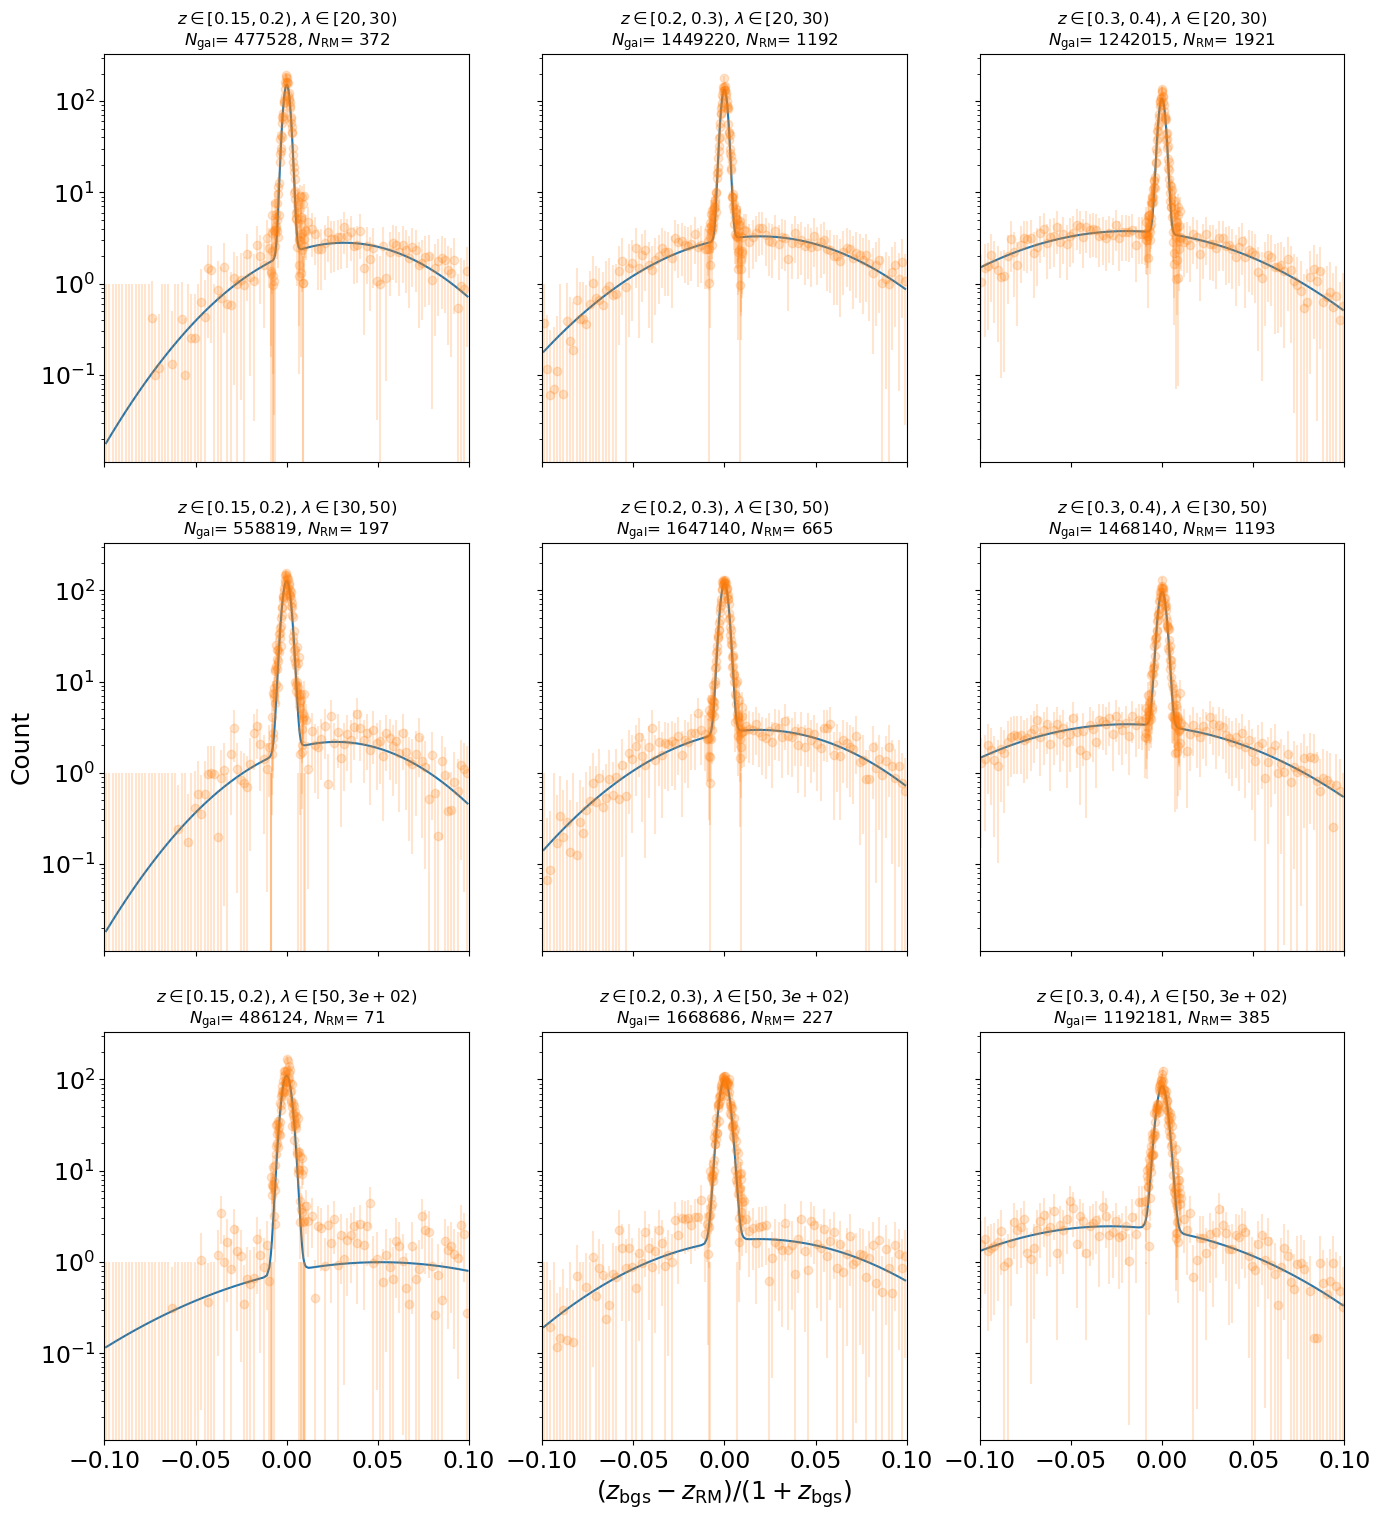

In [377]:
chains_dir = 'chains/'
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,18), sharex='all', sharey='all')
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):

        ##Apply binning
        cut = (rm_data_matched['LAMBDA'] >= lmda_bin[0]) & (rm_data_matched['LAMBDA'] < lmda_bin[1])
        cut &=(rm_data_matched['Z_LAMBDA'] >= z_bin[0]) & (rm_data_matched['Z_LAMBDA'] < z_bin[1])
        rm_bin = rm_data_matched[cut]

        input_key = 'lmda{:d}_{:d}_z{:.2f}_{:.2f}'.format(lmda_bin[0], lmda_bin[1], z_bin[0], z_bin[1])
        bin_dict = input_dict[input_key]
        input_key = input_key.replace('.','p')
        
        y_data = bin_dict['y_data']
        y_err = bin_dict['y_err']
        x_data = bin_dict['x_data']

        filename = chains_dir+input_key+'.h5py'
        f = h5py.File(filename,'r')
        chain = np.array(f['chains'])
        f.close()
        #flatchain = chain.reshape((-1,Ndim)).T
        best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model, \
                                                            Ndim, x_data, y_data, y_err, verbose=True)

        fit = model(best_fit_params[:,0], x_data)
        y_data = bin_dict['y_data']
        y_err = bin_dict['y_err']
        x_data = bin_dict['x_data']
        
        ax[i,j].plot(x_data, fit)
        ax[i,j].errorbar(x_data, y_data, yerr= y_err, linestyle='none', marker='o', alpha=0.2)
        ax[i,j].set_yscale('log')
        #ax[i,j].set_yscale('symlog', linthresh=1)
        ax[i,j].set_xlim([-0.1,0.1])
            #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
        ax[i,j].tick_params(axis='both', which='major', labelsize=17)
        ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                              r'$\lambda \in [{:.2g},{:.2g})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                              r'$N_{\rm gal}$' + '= {:d}'.format(len(rm_bin)) \
                              + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(rm_bin['ID']))))
            #ax[i,j].axhline(0.0, linestyle='--')
           
        ax[1,0].set_ylabel(r"Count", fontsize=18)
        ax[2,1].set_xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$"  , fontsize=18)
        
plt.show()   

In [378]:
params_list = [r'$A_1$', r'$\mu_1$', r'$\sigma_1$', '$A_2$', r'$\mu_2$', r'$\sigma_2$']

In [379]:
np.shape(best_fit_params)

(6, 3)

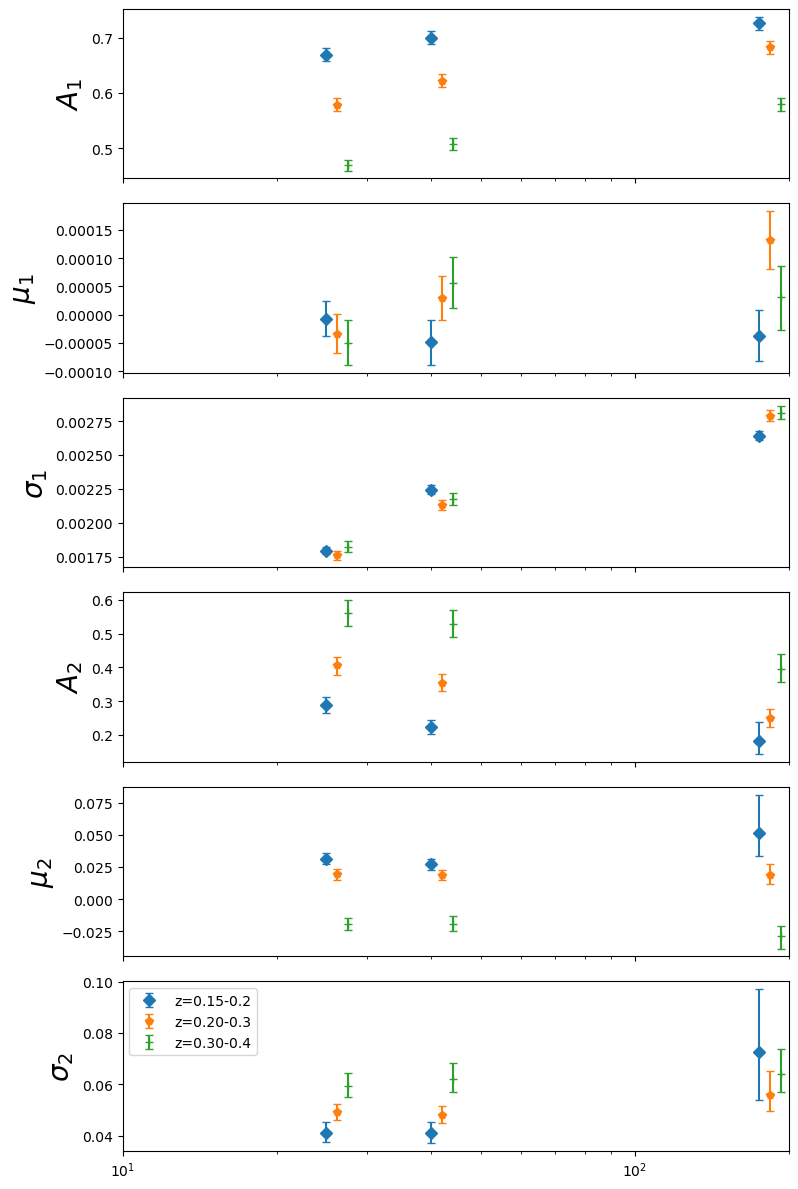

In [381]:
## Plotting parameter trends
fontsize=20
legendsize=14
fig, axs = plt.subplots(6, 1, figsize=(8,12), tight_layout=True, sharex=True)

## With respect to redshift
shift = 1
markers = ['D', 'p', '+']
for i, z_bin in enumerate(z_bins):
    lmda_bin_cent = []
    for j, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)

        lmda_bin_cent.append((lmda_bin[0]+lmda_bin[1])/2)


        input_key = 'lmda{:d}_{:d}_z{:.2f}_{:.2f}'.format(lmda_bin[0], lmda_bin[1], z_bin[0], z_bin[1])
        input_dict[input_key] = bin_dict
        input_key = input_key.replace('.','p')
        
        y_data = bin_dict['y_data']
        y_err = bin_dict['y_err']
        x_data = bin_dict['x_data']

        filename = chains_dir+input_key+'.h5py'
        try:
            f = h5py.File(filename,'r')
        except:
            continue


        chain = np.array(f['chains'])
        best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model, \
                                                            Ndim, x_data, y_data, y_err, verbose=False)

        if j == 0: pmax_param_bin = [best_fit_params]
        else: pmax_param_bin = np.vstack((pmax_param_bin,[best_fit_params]))

    lmda_bin_cent = np.array(lmda_bin_cent)
    for n, param in enumerate(params_list):
        #print(pmax_param_bin)
        yerr = [pmax_param_bin[:,n,2], pmax_param_bin[:,n,1]] ##Specify the lower and upper bounds
        y = pmax_param_bin[:,n,0]
        axs[n].errorbar(shift*lmda_bin_cent, y, yerr=yerr, fmt=markers[i], capsize=3, label='z={:.2f}-{:.2}'.format(z_bin[0], z_bin[1]))
        axs[n].set_ylabel(param, fontsize=fontsize)
        axs[n].set_xscale('log')
        axs[n].set_xlim([10,200])

    shift *= 1.05
    

plt.legend()
plt.show()